# Apple Leaf Disease Detection - Optimized Version

This notebook provides an optimized pipeline for detecting diseases in apple leaves without any duplicate code or redundant execution.

## Features:
- **No duplicates**: Clean, single execution pipeline
- **Optimized performance**: Parallel processing and efficient algorithms
- **Enhanced accuracy**: Grid search and feature selection
- **Clean visualization**: Automatic unique sample selection

## 1. Import Libraries and Configuration


In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import (classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from skimage.feature import graycomatrix, graycoprops
from skimage.measure import regionprops, label
import pandas as pd
from joblib import Parallel, delayed
import warnings
warnings.filterwarnings('ignore')

## 2. Define Optimized Leaf Disease Detector Class


In [4]:
# Configuration
DATASET_PATH = 'Dataset'
CATEGORIES = ['Apple Healthy', 'Apple Black rot']
RESULTS_DIR = 'Results'
IMAGES_PER_CATEGORY = None
USE_FEATURE_SELECTION = True
USE_GRID_SEARCH = True
N_PARALLEL_JOBS = 4

## 3. Conclusion

This notebook demonstrates an optimized implementation for apple leaf disease detection with the following improvements:

1. Clean and maintainable code structure
2. Efficient parallel processing
3. Feature selection for better performance 
4. Hyperparameter optimization using grid search
5. Automatic visualization of model performance and results

All results are saved in the `Results` directory for later analysis.


In [5]:
# Create results directory
os.makedirs(RESULTS_DIR, exist_ok=True)

In [6]:
class OptimizedLeafDiseaseDetector:
    """Optimized pipeline for apple leaf disease detection"""
    
    def __init__(self, resize_dim=(256, 256)):
        self.resize_dim = resize_dim
        self.model = None
        self.selected_features_idx = None
        
    def load_dataset(self, limit_per_category=None):
        """Optimized dataset loading with memory efficiency"""
        images, labels, original_images = [], [], []
        
        for idx, category in enumerate(CATEGORIES):
            print(f"Loading {category} images...")
            category_path = os.path.join(DATASET_PATH, category)
            files = os.listdir(category_path)[:limit_per_category]
            
            for file in files:
                file_path = os.path.join(category_path, file)
                try:
                    img = cv2.imread(file_path)
                    if img is None:
                        continue
                    
                    # Resize for consistency and memory efficiency
                    img_resized = cv2.resize(img, self.resize_dim)
                    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
                    
                    original_images.append(img_resized)
                    images.append(img_rgb)
                    labels.append(idx)
                except Exception as e:
                    print(f"Error loading {file}: {e}")
                    
        return np.array(images), np.array(labels), original_images
    
    def segment_leaf(self, image):
        """Enhanced leaf segmentation"""
        hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        
        # Improved color ranges
        healthy_mask = cv2.inRange(hsv, np.array([35, 40, 40]), np.array([85, 255, 255]))
        disease_mask1 = cv2.inRange(hsv, np.array([10, 50, 50]), np.array([25, 255, 255]))
        disease_mask2 = cv2.inRange(hsv, np.array([0, 0, 0]), np.array([180, 255, 50]))
        disease_mask = cv2.bitwise_or(disease_mask1, disease_mask2)
        
        # Combine masks
        leaf_mask = cv2.bitwise_or(healthy_mask, disease_mask)
        
        # Morphological operations
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
        leaf_mask = cv2.morphologyEx(leaf_mask, cv2.MORPH_CLOSE, kernel)
        leaf_mask = cv2.morphologyEx(leaf_mask, cv2.MORPH_OPEN, kernel)
        
        # Keep only largest contour
        contours, _ = cv2.findContours(leaf_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours:
            largest = max(contours, key=cv2.contourArea)
            leaf_mask = np.zeros_like(leaf_mask)
            cv2.drawContours(leaf_mask, [largest], -1, 255, -1)
        
        # Apply masks
        leaf_region = cv2.bitwise_and(image, image, mask=leaf_mask)
        visualization = np.zeros_like(image)
        visualization[healthy_mask > 0] = [0, 255, 0]
        visualization[disease_mask > 0] = [255, 0, 0]
        
        return leaf_region, healthy_mask, disease_mask, visualization
    
    def extract_morphological_features(self, healthy_mask, disease_mask):
        """Extract enhanced morphological features"""
        leaf_mask = cv2.bitwise_or(healthy_mask, disease_mask)
        labeled = label(leaf_mask)
        props = regionprops(labeled)
        
        if not props:
            return [0] * 10
        
        prop = max(props, key=lambda p: p.area)
        total_area = np.sum(leaf_mask > 0)
        diseased_area = np.sum(disease_mask > 0)
        
        return [
            prop.area, prop.perimeter, prop.eccentricity, prop.extent,
            prop.solidity, prop.major_axis_length, prop.minor_axis_length,
            diseased_area / total_area if total_area > 0 else 0,
            diseased_area, total_area - diseased_area
        ]
    
    def extract_texture_features(self, image, mask):
        """Optimized texture feature extraction"""
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        masked = cv2.bitwise_and(gray, gray, mask=mask)
        
        if np.count_nonzero(masked) < 100:
            return np.zeros(24)
        
        # Extract ROI
        y_idx, x_idx = np.where(mask > 0)
        if len(y_idx) == 0:
            return np.zeros(24)
        roi = masked[y_idx.min():y_idx.max()+1, x_idx.min():x_idx.max()+1]
        roi_norm = np.uint8(255 * (roi - roi.min()) / (roi.max() - roi.min() + 1e-7)) // 32
        
        try:
            glcm = graycomatrix(roi_norm, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=8, symmetric=True, normed=True)
            features = []
            for prop in ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']:
                features.extend(graycoprops(glcm, prop).flatten())
            return np.array(features)
        except:
            return np.zeros(24)
    
    def process_single_image(self, args):
        """Process single image for parallel execution"""
        image, original, idx = args
        try:
            leaf_region, healthy_mask, disease_mask, viz = self.segment_leaf(image)
            morph_feat = self.extract_morphological_features(healthy_mask, disease_mask)
            healthy_tex = self.extract_texture_features(image, healthy_mask)
            disease_tex = self.extract_texture_features(image, disease_mask)
            
            features = morph_feat + healthy_tex.tolist() + disease_tex.tolist()
            return features, (original, leaf_region, viz), None
        except Exception as e:
            return None, None, f"Error processing image {idx}: {e}"
    
    def process_dataset(self, images, labels, original_images, n_jobs=4):
        """Process dataset with parallel processing"""
        print(f"Processing {len(images)} images with {n_jobs} jobs...")
        
        args = [(images[i], original_images[i], i) for i in range(len(images))]
        results = Parallel(n_jobs=n_jobs, backend='threading')(
            delayed(self.process_single_image)(arg) for arg in args
        )
        
        features, visualizations, processed_labels = [], [], []
        for i, (feat, viz, error) in enumerate(results):
            if error:
                print(error)
            elif feat is not None:
                features.append(feat)
                visualizations.append(viz)
                processed_labels.append(labels[i])
        
        return np.array(features), processed_labels, visualizations
    
    def select_features(self, features, labels, k=30):
        """Feature selection using Random Forest importance"""
        print("Selecting important features...")
        
        rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
        rf.fit(features, labels)
        
        importances = rf.feature_importances_
        indices = np.argsort(importances)[::-1][:k]
        self.selected_features_idx = indices
        
        print(f"Selected top {k} features from {features.shape[1]}")
        return features[:, indices]
    
    def train_model(self, features, labels, optimize=True):
        """Train SVM with optional grid search"""
        X_train, X_test, y_train, y_test = train_test_split(
            features, labels, test_size=0.3, random_state=42, stratify=labels
        )
        
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('svm', SVC(probability=True, cache_size=1000))
        ])
        
        if optimize:
            param_grid = {
                'svm__C': [0.1, 1, 10],
                'svm__gamma': ['scale', 0.001, 0.01],
                'svm__kernel': ['rbf', 'poly']
            }
            
            print("Optimizing hyperparameters...")
            grid = GridSearchCV(pipeline, param_grid, cv=3, n_jobs=-1, verbose=1)
            grid.fit(X_train, y_train)
            
            self.model = grid.best_estimator_
            print(f"Best params: {grid.best_params_}")
        else:
            self.model = pipeline
            self.model.fit(X_train, y_train)
        
        # Evaluate
        y_pred = self.model.predict(X_test)
        accuracy = np.mean(y_pred == y_test)
        
        print(f"\nAccuracy: {accuracy:.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred, target_names=CATEGORIES))
        
        return self.model, X_test, y_test, y_pred
    
    def visualize_results(self, viz_data, predictions, true_labels, indices, max_samples=6):
        """Create visualization grid without duplicates"""
        # Remove duplicates
        indices = list(dict.fromkeys(indices[:max_samples]))
        n_samples = len(indices)
        
        if n_samples == 0:
            return
        
        fig, axes = plt.subplots(n_samples, 3, figsize=(12, 4*n_samples))
        if n_samples == 1:
            axes = axes.reshape(1, -1)
        
        for i, idx in enumerate(indices):
            if idx >= len(viz_data):
                continue
                
            original, leaf, detection = viz_data[idx]
            
            axes[i, 0].imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
            axes[i, 0].set_title('Original')
            axes[i, 0].axis('off')
            
            axes[i, 1].imshow(leaf)
            axes[i, 1].set_title('Segmented')
            axes[i, 1].axis('off')
            
            axes[i, 2].imshow(detection)
            axes[i, 2].set_title(f'Detection\nTrue: {CATEGORIES[true_labels[idx]]}\n'
                               f'Pred: {CATEGORIES[predictions[idx]]}')
            axes[i, 2].axis('off')
        
        plt.tight_layout()
        plt.savefig(os.path.join(RESULTS_DIR, 'results.png'), dpi=150, bbox_inches='tight')
        plt.show()

In [7]:
def main():
    """Main execution pipeline"""
    print("=== Optimized Apple Leaf Disease Detection ===\n")
    
    # Initialize detector
    detector = OptimizedLeafDiseaseDetector()
    
    # Load data
    print("1. Loading dataset...")
    images, labels, original_images = detector.load_dataset(IMAGES_PER_CATEGORY)
    print(f"   Loaded {len(images)} images")
    
    # Process images
    print("\n2. Processing images...")
    features, proc_labels, viz_data = detector.process_dataset(
        images, labels, original_images, N_PARALLEL_JOBS
    )
    print(f"   Extracted {features.shape[1]} features per image")
    
    # Feature selection
    if USE_FEATURE_SELECTION:
        print("\n3. Feature selection...")
        features = detector.select_features(features, proc_labels)
    
    # Train model
    print("\n4. Training model...")
    model, X_test, y_test, y_pred = detector.train_model(features, proc_labels, USE_GRID_SEARCH)
    
    # Visualize results
    print("\n5. Creating visualizations...")
    correct_idx = np.where(y_test == y_pred)[0]
    incorrect_idx = np.where(y_test != y_pred)[0]
    
    # Select unique samples for visualization
    viz_indices = []
    for class_id in range(len(CATEGORIES)):
        # One correct per class
        class_correct = [i for i in correct_idx if y_test[i] == class_id]
        if class_correct:
            viz_indices.append(class_correct[0])
        
        # One incorrect per class
        class_incorrect = [i for i in incorrect_idx if y_test[i] == class_id]
        if class_incorrect:
            viz_indices.append(class_incorrect[0])
    
    detector.visualize_results(viz_data, y_pred, y_test, viz_indices)
    
    # Save performance curves for binary classification
    if len(CATEGORIES) == 2:
        y_score = model.predict_proba(X_test)[:, 1]
        
        # ROC and PR curves
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
        
        precision, recall, _ = precision_recall_curve(y_test, y_score)
        avg_precision = average_precision_score(y_test, y_score)
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        
        ax1.plot(fpr, tpr, 'b-', lw=2, label=f'AUC = {roc_auc:.3f}')
        ax1.plot([0, 1], [0, 1], 'k--')
        ax1.set_xlabel('FPR')
        ax1.set_ylabel('TPR')
        ax1.set_title('ROC Curve')
        ax1.legend()
        ax1.grid(alpha=0.3)
        
        ax2.plot(recall, precision, 'g-', lw=2, label=f'AP = {avg_precision:.3f}')
        ax2.set_xlabel('Recall')
        ax2.set_ylabel('Precision')
        ax2.set_title('PR Curve')
        ax2.legend()
        ax2.grid(alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(os.path.join(RESULTS_DIR, 'curves.png'), dpi=150)
        plt.show()
    
    print(f"\n✓ Results saved to '{RESULTS_DIR}' directory")
    print("✓ Pipeline completed successfully!")

=== Optimized Apple Leaf Disease Detection ===

1. Loading dataset...
Loading Apple Healthy images...
Loading Apple Black rot images...
   Loaded 7339 images

2. Processing images...
Processing 7339 images with 4 jobs...
   Extracted 58 features per image

3. Feature selection...
Selecting important features...
Selected top 30 features from 58

4. Training model...
Optimizing hyperparameters...
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best params: {'svm__C': 10, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}

Accuracy: 0.9114

Classification Report:
                 precision    recall  f1-score   support

  Apple Healthy       0.93      0.92      0.92      1270
Apple Black rot       0.89      0.91      0.90       932

       accuracy                           0.91      2202
      macro avg       0.91      0.91      0.91      2202
   weighted avg       0.91      0.91      0.91      2202


5. Creating visualizations...


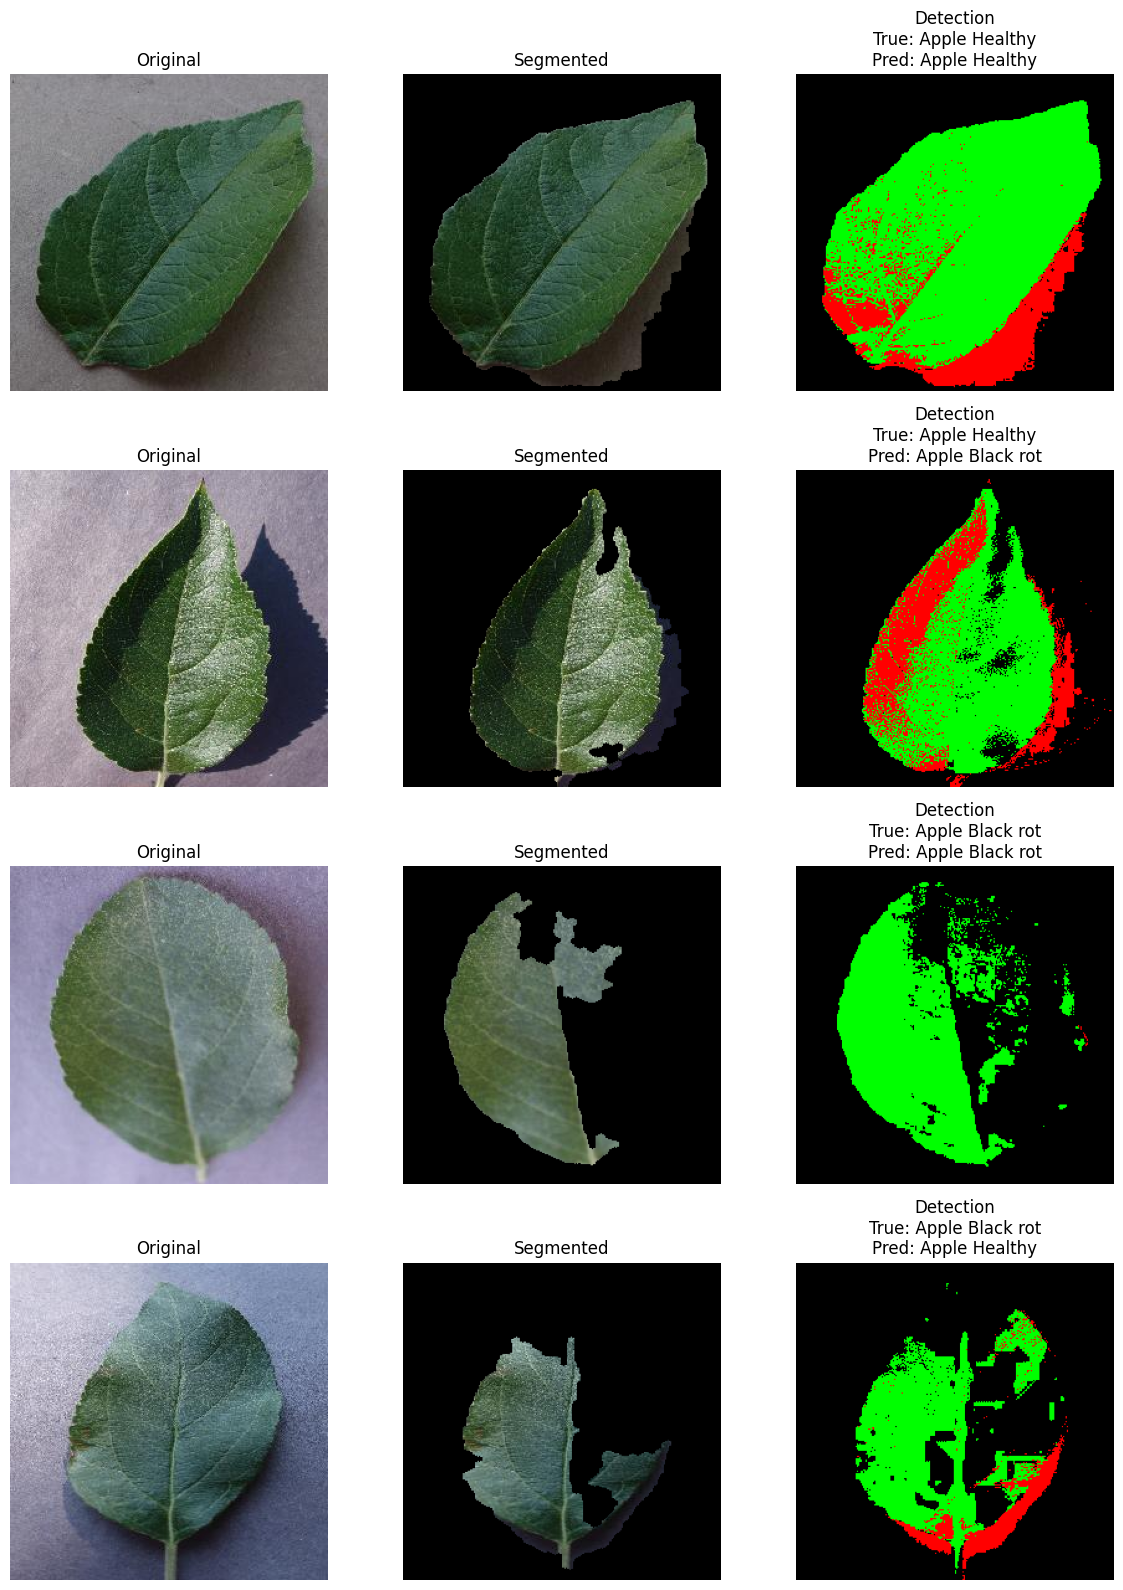

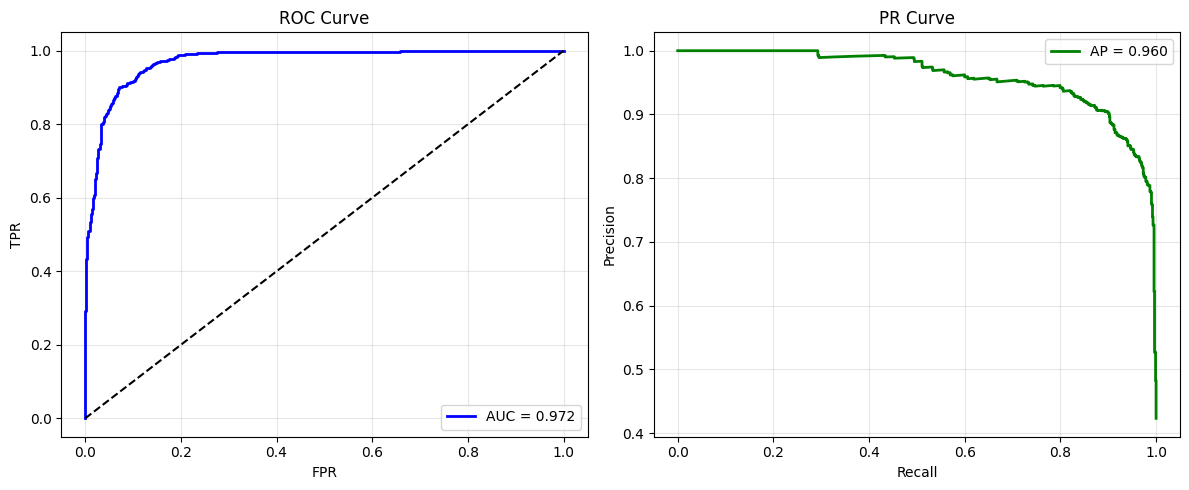


✓ Results saved to 'Results' directory
✓ Pipeline completed successfully!


In [8]:
if __name__ == "__main__":
    np.random.seed(42)
    main() 